## MOUNT Google Drive

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!lscpu |grep 'Model name'
!lscpu |grep 'Core(s) per socket:'
!free -h
!lscpu |grep 'Thread(s) per core'

Model name:          Intel(R) Xeon(R) CPU @ 2.00GHz
Core(s) per socket:  4
              total        used        free      shared  buff/cache   available
Mem:            51G        987M         47G        1.2M        2.1G         49G
Swap:            0B          0B          0B
Thread(s) per core:  2


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec 22 12:56:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## IMPORTS

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import numpy as np
import random
import os, sys, time
from PIL import Image
import torchvision.transforms as T
import scipy.ndimage as sc
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

sys.path.append('/content/drive/MyDrive/ml_epfl/ml_road_segmentation/script/')
#from helper_functions import *

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## CONSTANTS

In [6]:
CHECKPOINT_PATH ="/content/drive/MyDrive/ml_epfl/ml_road_segmentation/checkpoint/current_checkpoint_filter.pt"
BEST_MODEL_PATH ="/content/drive/MyDrive/ml_epfl/ml_road_segmentation/checkpoint/best_model_filter.pt"
NBR_EPOCHS = 100
BATCH_SIZE = 1
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-6
GAMMA = 0.99
K_FOLD = 4
VALIDATION_SET_IDX = 0
BATCH_SIZE_VAL = 5
SEED = 0

## AUXILIARY FUNCTIONS

In [7]:
def format_time(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

In [8]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state:            checkpoint we want to save
    is_best:          boolean to indicates if it is the best checkpoint
    checkpoint_path:  path to save checkpoint
    best_model_path:  path to save best model
    """
    torch.save(state, checkpoint_path)
    # if it is a best model, save the model's weights
    if is_best:
        torch.save(model.state_dict(), best_model_path)

In [9]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model:           model that we want to load checkpoint parameters into       
    optimizer:       optimizer we defined in previous training
    
    Return model, optimizer, scheduler, epoch value, f1 score
    """
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # Get epoch number, f1_max, scheduler
    epoch = checkpoint['epoch']
    f1_max = checkpoint['f1_max']
    scheduler = checkpoint['scheduler']
    f1_validation = checkpoint['f1_validation']
    acc_validation = checkpoint['acc_validation']
    f1_training = checkpoint['scheduler']
    acc_training = checkpoint['acc_training']


    return model, optimizer, scheduler, epoch, f1_max, f1_validation, acc_validation, f1_training, acc_training

In [102]:
# FUNCTIONS FOR DATASET AUGMENTATION

#Constants
DIM_IMG = 400
DIM_IMG_CROP=DIM_IMG//2
NB_ROT = 0
ANGLE_ROTATION = 22.
SHARPNESS = 5
CONTRAST = 0.75
    
# Old Rotation
def rotation_old(imgs):
    rot_imgs = [T.functional.rotate(imgs[i], ANGLE_ROTATION*(idx_rot), expand=False)
                for idx_rot in range(NB_ROT)
                for i in range(len(imgs))
                ]
    return rot_imgs

# Rotation with mirroring
def rotation(imgs):
    rot_imgs = [torch.from_numpy(sc.rotate(imgs[i], ANGLE_ROTATION*(idx_rot+1), axes =(1,2), reshape=False, mode ='mirror'))
                for idx_rot in range(NB_ROT)
                for i in range(len(imgs))
               ]
    return rot_imgs

#Crop and resize
def crop(imgs):
    cropped_imgs = [T.Resize(size=DIM_IMG)(T.FiveCrop(size=DIM_IMG_CROP)(imgs[i])[tuple_i])
                    for tuple_i in range(5)
                    for i in range(len(imgs))
                   ]
    return cropped_imgs

#Adjust sharpness
def sharp(imgs):
    sharp_imgs = [T.functional.adjust_sharpness(imgs[i],SHARPNESS) 
                    for i in range(len(imgs))
                  ]
    return sharp_imgs


#Adjust contrast
def contrast(imgs):
    contrast_imgs = [T.functional.adjust_contrast(imgs[i],CONTRAST) 
                    for i in range(len(imgs))
                  ]
    return contrast_imgs

def compose_all_functions_for_data_X(imgs):
    #c = imgs + crop(imgs)
    #r = c + rotation(c)
    s = sharp(imgs)
    c = contrast(s)
    r = c + rotation(c)
    return r

def compose_all_functions_for_data_Y(imgs):
    #c = imgs + crop(imgs)
    #r = c + rotation(c)
    r = imgs + rotation(imgs)
    return r

def load_train_dataset():
    root_dir = "/content/drive/MyDrive/ml_epfl/ml_road_segmentation/data/training/"
    image_dir = root_dir + "images/"
    gt_dir = root_dir + "groundtruth/"
    files = os.listdir(image_dir)
    n = len(files)

    to_tensor = T.ToTensor()
    imgs = [to_tensor(Image.open(image_dir + files[i])) for i in range(n)]
    gt_imgs = [to_tensor(Image.open(gt_dir + files[i])) for i in range(n)]
    return (imgs, gt_imgs)

## UNET MODEL

In [11]:
def double_conv(nbr_channels_in, nbr_channels_out):
    return nn.Sequential(
      nn.Conv2d(nbr_channels_in, nbr_channels_out, (3,3), padding=(1, 1)),
      nn.BatchNorm2d(nbr_channels_out),
      nn.ReLU(),
      nn.Conv2d(nbr_channels_out, nbr_channels_out, (3,3), padding=(1, 1)),
      nn.ReLU(),
      nn.BatchNorm2d(nbr_channels_out),
)


def one_step_up(x, x_d_i, pre_up_i, up_i):
    return up_i(torch.cat((pre_up_i(x), x_d_i), dim=1))


class u_net(nn.Module):
    def __init__(self):
        super(u_net, self).__init__()

        self.down_pooling = nn.MaxPool2d(2, 2)

        # Convolution Downwards
        self.down_1 = double_conv(3, 64) 
        self.down_2 = double_conv(64, 128)
        self.down_3 = double_conv(128, 256)
        self.down_4 = double_conv(256, 512)
        self.middle =  double_conv(512, 1024)
        
        # Upconvolution
        self.pre_up_1 = nn.ConvTranspose2d(1024, 512, (2, 2), (2, 2))
        self.up_1 = double_conv(512 + 512, 512)
                
        self.pre_up_2 = nn.ConvTranspose2d(512, 256, (2, 2), (2, 2))
        self.up_2 = double_conv(256 + 256, 256)
          
        self.pre_up_3 = nn.ConvTranspose2d(256, 128, (2, 2), (2, 2))
        self.up_3 = double_conv(128 + 128, 128)

        self.pre_up_4 = nn.ConvTranspose2d(128, 64, (2, 2), (2, 2))
        self.up_4 = double_conv(64 + 64, 64)

        self.final_convolution = nn.Conv2d(64, 2, (1,1))
        

    def forward(self, x):
        x_d_1 = self.down_1(x)
        x_d_2 = self.down_2(self.down_pooling(x_d_1))
        x_d_3 = self.down_3(self.down_pooling(x_d_2))
        x_d_4 = self.down_4(self.down_pooling(x_d_3))

        x = self.middle(self.down_pooling(x_d_4))

        x = one_step_up(x, x_d_4, self.pre_up_1, self.up_1)
        x = one_step_up(x, x_d_3, self.pre_up_2, self.up_2)
        x = one_step_up(x, x_d_2, self.pre_up_3, self.up_3)
        x = one_step_up(x, x_d_1, self.pre_up_4, self.up_4)
        
        return self.final_convolution(x)


## DATASET LOADING

In [103]:
class imagesDataset(Dataset): 
    def __init__(self, K_fold, validation_set_idx, batch_size_val, seed):
        X, Y = load_train_dataset()

        #tresholding ground_truth values
        Y = [(y > 0.5).long() for y in Y]
        shape_y = Y[0].shape
        
        #shuffling
        random.seed(seed)
        idx_list = list(range(len(X)))
        random.shuffle(idx_list)
        random.seed()
        X = [X[idx] for idx in idx_list]
        Y = [Y[idx] for idx in idx_list]
        
        #K_fold separation
        fold_size = len(X) // K_fold
        start_validation_idx = validation_set_idx * fold_size
        end_validation_idx = start_validation_idx + fold_size
        self.X_train = X[slice(0, start_validation_idx)] + X[slice(end_validation_idx, None)]
        self.Y_train = Y[slice(0, start_validation_idx)] + Y[slice(end_validation_idx, None)]
        self.X_validation = X[slice(start_validation_idx, end_validation_idx)]
        self.Y_validation = Y[slice(start_validation_idx, end_validation_idx)]

        #data augmentation
        self.X_train = compose_all_functions_for_data_X(self.X_train)
        self.Y_train = compose_all_functions_for_data_Y(self.Y_train)
        self.X_validation = compose_all_functions_for_data_X(self.X_validation)
        self.Y_validation = compose_all_functions_for_data_Y(self.Y_validation)
        self.n_samples = len(self.X_train)

        #2nd shuffling
        random.seed(seed)
        idx_list = list(range(len(self.X_train)))
        random.shuffle(idx_list)
        random.seed()
        self.X_train = [self.X_train[idx] for idx in idx_list]
        self.Y_train = [self.Y_train[idx] for idx in idx_list]
        
        #casting into tensors
        self.X_train = torch.stack(self.X_train)
        self.X_validation = torch.stack(self.X_validation)
        self.Y_train = torch.reshape(torch.stack(self.Y_train) , (-1, shape_y[1], shape_y[2]))
        self.Y_validation = torch.reshape(torch.stack(self.Y_validation) , (-1, shape_y[1], shape_y[2]))

        #creating dataloader for validation data
        class dataset_validation(Dataset):
            def __init__(s,x,y):
                s.x = x
                s.y = y
                s.size = len(s.x)
            def __getitem__(s, index):
                return s.x[index], s.y[index]
            def __len__(s):
                return s.size
               
        self.validation_data_loader = torch.utils.data.DataLoader(
            dataset_validation(self.X_validation, self.Y_validation),
            batch_size = batch_size_val, shuffle = False)
        
        
    def __getitem__(self, index):
        return self.X_train[index], self.Y_train[index]

    def __len__(self):
        return self.n_samples
    
    def get_validation_dataloader(self):
        return self.validation_data_loader


dataset = imagesDataset(K_FOLD, VALIDATION_SET_IDX, BATCH_SIZE_VAL, SEED)
train_loader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True)
validation_dataloader = dataset.get_validation_dataloader()
print(len(dataset))

75


Text(0.5, 1.0, 'Image rotated and mirrored')

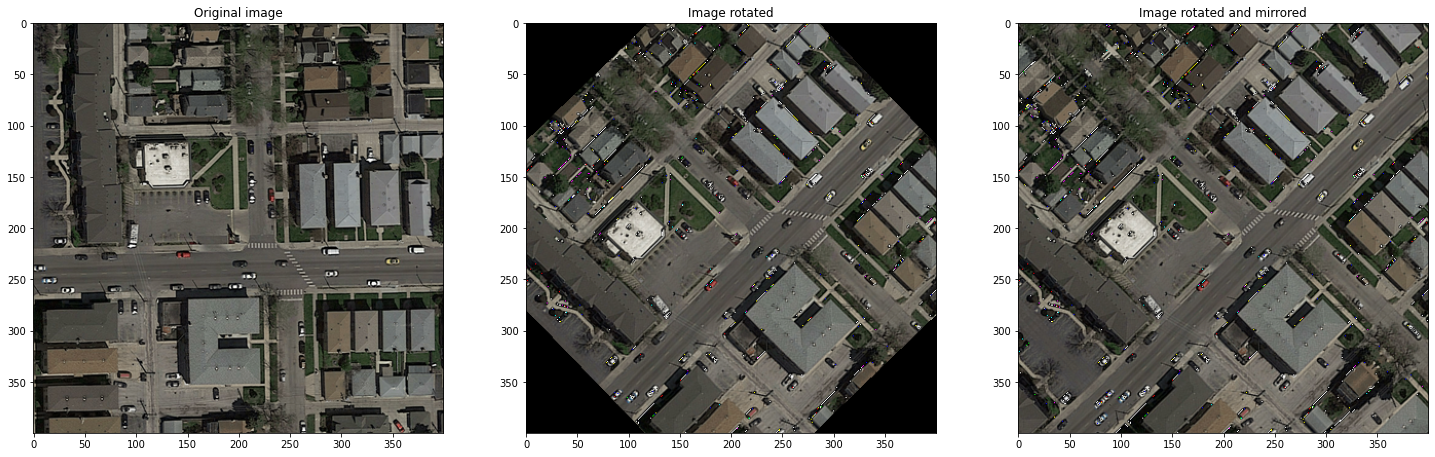

In [95]:
#VERIFYING THE FILTERING

to_tensor = T.ToTensor() 
toPIL = T.ToPILImage()
idx_image = 2
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 35))
ax1.imshow(toPIL(dataset.X_train[idx_image]))
ax2.imshow(toPIL(torch.from_numpy(sc.rotate(dataset.X_train[idx_image], ANGLE_ROTATION*2, axes =(1,2), reshape=False))))
ax3.imshow(toPIL(torch.from_numpy(sc.rotate(dataset.X_train[idx_image], ANGLE_ROTATION*2, axes =(1,2), reshape=False, mode ='mirror'))))

ax1.set_title("Original image")
ax2.set_title(f"Image rotated")
ax3.set_title(f"Image rotated and mirrored")

## TRAINING

In [27]:
def compute_scores(loader):
    #computing F1 score on validation data
    tp, fp, fn, tn = 0, 0, 0, 0
    for (data, target) in loader:
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            output = model(data)
        prediction = torch.argmax(output, dim = 1)
        confusions = prediction / target
        tp += torch.sum(confusions == 1).item()
        fp += torch.sum(confusions == float('inf')).item()
        fn += torch.sum(confusions == 0).item()
        tn += torch.sum(confusions == float("nan")).item()
    f1_score = 2 * tp / (2 * tp + fp + fn)
    accuracy = (tp + tn) / (tp + tn + fp+ fn)
    return f1_score, accuracy

In [28]:
def train(n_epochs, data_loader, model, optimizer, scheduler, criterion, device, checkpoint_path, best_model_path, f1_init):
    train_loader = data_loader
    validation_loader = train_loader.dataset.get_validation_dataloader()
    f1_max = f1_init
    
    save_f1_validation = []
    save_acc_validation = []
    save_f1_training = []
    save_acc_training = []

    for epoch in range(n_epochs):
        start_time_epoch = time.time()
        loss_list = []
        
        # Train the model for one epoch
        model.train()
        for (data, target) in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
        loss_epoch = np.mean(loss_list)

        model.eval()
        #computing scores on validation data
        f1_score_val, accuracy_score_val = compute_scores(validation_loader)
        save_f1_validation.append(f1_score_val)
        save_acc_validation.append(accuracy_score_val)

        #computing scores on training data
        f1_score_train, accuracy_score_train = compute_scores(train_loader)
        save_f1_training.append(f1_score_train)
        save_acc_training.append(accuracy_score_train)

        end_time_epoch = time.time()

        # Prepare saving of the model
        checkpoint = {
            'epoch': epoch,
            'f1_max': f1_max,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler,
            'f1_validation' : save_f1_validation,
            'acc_validation' : save_acc_validation,
            'f1_training' : save_f1_training,
            'acc_training' : save_acc_training,
        }

        if f1_score_val > f1_max:
            save_ckp(checkpoint, True, checkpoint_path, best_model_path)
            f1_max = f1_score_val
        
        save_ckp(checkpoint, False, checkpoint_path, best_model_path)

        print(f"Epoch {epoch} || Loss:{loss_epoch:.6f} || Training F1 {f1_score_train:.6f} || Training Accuracy {accuracy_score_train:.6f} || Validation F1 {f1_score_val:.6f} || Validation Accuracy {accuracy_score_val:.6f} || Max F1 {f1_max:.6f} || LR {scheduler.get_last_lr()[0]:.6f} || Duration {format_time(end_time_epoch-start_time_epoch)}"+"\n")  
        scheduler.step()

In [104]:
LOAD_BEST_MODEL = False 
LOAD_LAST_CHECKPOINT = not LOAD_BEST_MODEL
COLD_START = True

# Declare UNET model, otimizer, adaptative learning rate and loss function
model =  u_net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = ExponentialLR(optimizer, GAMMA)
criterion = nn.CrossEntropyLoss()
f1_max = 0

if not COLD_START:
    if LOAD_LAST_CHECKPOINT and not LOAD_BEST_MODEL:
        model, optimizer, scheduler, epoch, f1_max, _ , _, _, _  = load_ckp(CHECKPOINT_PATH, model, optimizer)
    
    if not LOAD_LAST_CHECKPOINT and LOAD_BEST_MODEL:
        model.load_state_dict(torch.load(BEST_MODEL_PATH))

In [105]:
train(NBR_EPOCHS, train_loader, model, optimizer, scheduler, criterion, device, CHECKPOINT_PATH, BEST_MODEL_PATH, f1_max)

Epoch 0 || Loss:0.628292 || Training F1 0.418466 || Training Accuracy 0.264595 || Validation F1 0.433999 || Validation Accuracy 0.277139 || Max F1 0.433999 || LR 0.001000 || Duration 00:00:10

Epoch 1 || Loss:0.442471 || Training F1 0.570397 || Training Accuracy 0.398990 || Validation F1 0.583383 || Validation Accuracy 0.411815 || Max F1 0.583383 || LR 0.000990 || Duration 00:00:10

Epoch 2 || Loss:0.356208 || Training F1 0.588538 || Training Accuracy 0.416971 || Validation F1 0.627998 || Validation Accuracy 0.457724 || Max F1 0.627998 || LR 0.000980 || Duration 00:00:10

Epoch 3 || Loss:0.332588 || Training F1 0.563121 || Training Accuracy 0.391906 || Validation F1 0.572768 || Validation Accuracy 0.401314 || Max F1 0.627998 || LR 0.000970 || Duration 00:00:10

Epoch 4 || Loss:0.304418 || Training F1 0.487299 || Training Accuracy 0.322138 || Validation F1 0.400627 || Validation Accuracy 0.250490 || Max F1 0.627998 || LR 0.000961 || Duration 00:00:10

Epoch 5 || Loss:0.289577 || Trainin

## TEST RESULTS

In [13]:
# Utilities
to_tensor = T.ToTensor() 
toPIL = T.ToPILImage()

DIM_IMG_TEST = 608

In [106]:
def load_test_dataset():
    root_test_dir = "/content/drive/MyDrive/ml_epfl/ml_road_segmentation/data/test_set_images/"
    test_i = 'test_'
    n = len(os.listdir(root_test_dir))
    test_imgs = [to_tensor(Image.open(root_test_dir + test_i + str(idx_img) +'/'+ test_i + str(idx_img) + '.png')).reshape((1, 3, DIM_IMG_TEST, DIM_IMG_TEST)) for idx_img in range(1, n+1)]
    test_imgs_filtered = contrast(sharp(test_imgs))
    return test_imgs_filtered
  
test_images = load_test_dataset()

In [107]:
def make_predictions(model, test_images):
    model.eval()
    predicted_images = [torch.argmax(model(img.to(device)), dim = 1).cpu().float() for img in test_images]
    return predicted_images

predictions = make_predictions(model, test_images)

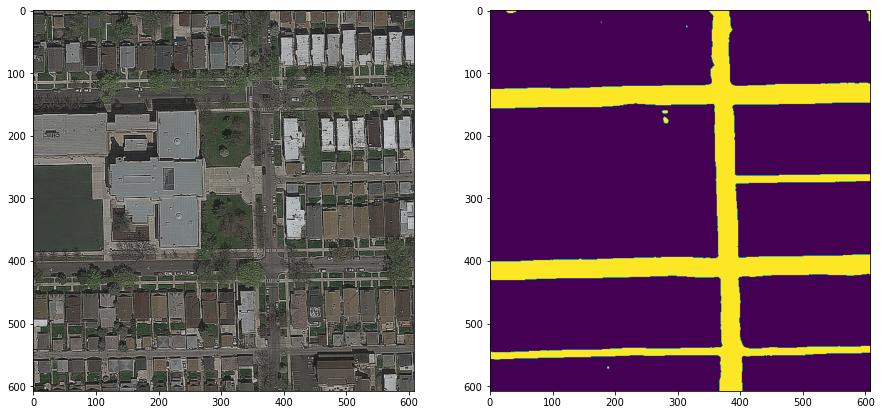

In [113]:
plt.figure(figsize=(15,15))
IMG_INDEX = 40
images = [toPIL(test_images[IMG_INDEX].reshape((3, DIM_IMG_TEST, DIM_IMG_TEST))), toPIL(predictions[IMG_INDEX])]
for i, image in enumerate(images):
    plt.subplot(1, 2, i+1)
    plt.imshow(image)

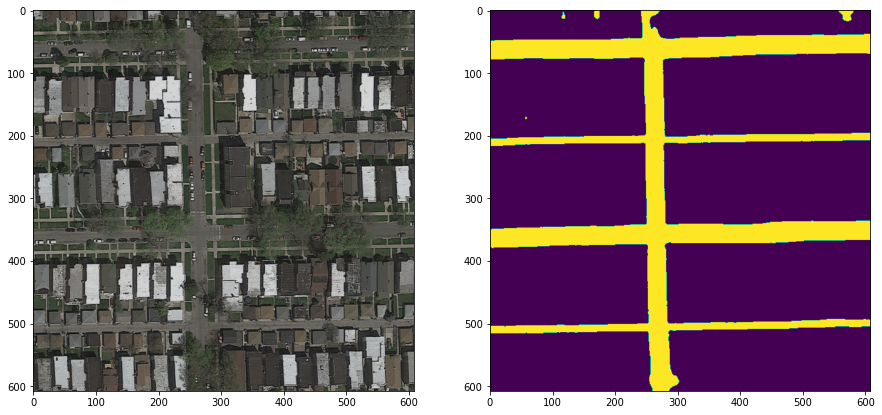

In [59]:
plt.figure(figsize=(15,15))
IMG_INDEX = 45
images = [toPIL(test_images[IMG_INDEX].reshape((3, DIM_IMG_TEST, DIM_IMG_TEST))), toPIL(predictions[IMG_INDEX])]
for i, image in enumerate(images):
    plt.subplot(1, 2, i+1)
    plt.imshow(image)

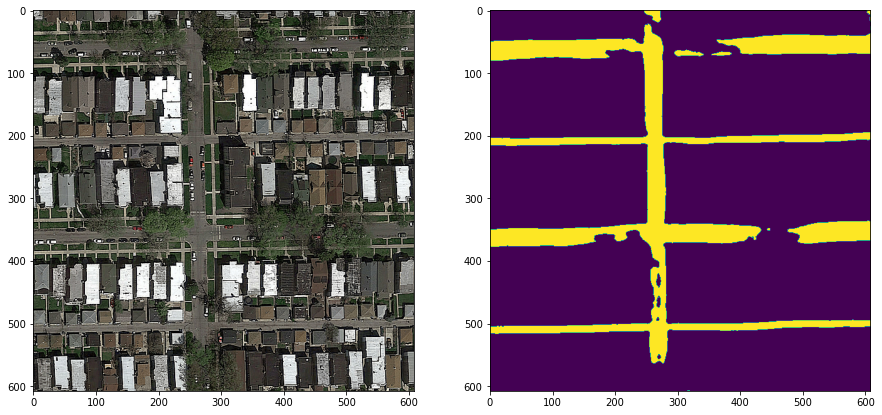

In [39]:
plt.figure(figsize=(15,15))
IMG_INDEX = 45
images = [toPIL(test_images[IMG_INDEX].reshape((3, DIM_IMG_TEST, DIM_IMG_TEST))), toPIL(predictions[IMG_INDEX])]
for i, image in enumerate(images):
    plt.subplot(1, 2, i+1)
    plt.imshow(image)

## JUST TO TRY ROTATION

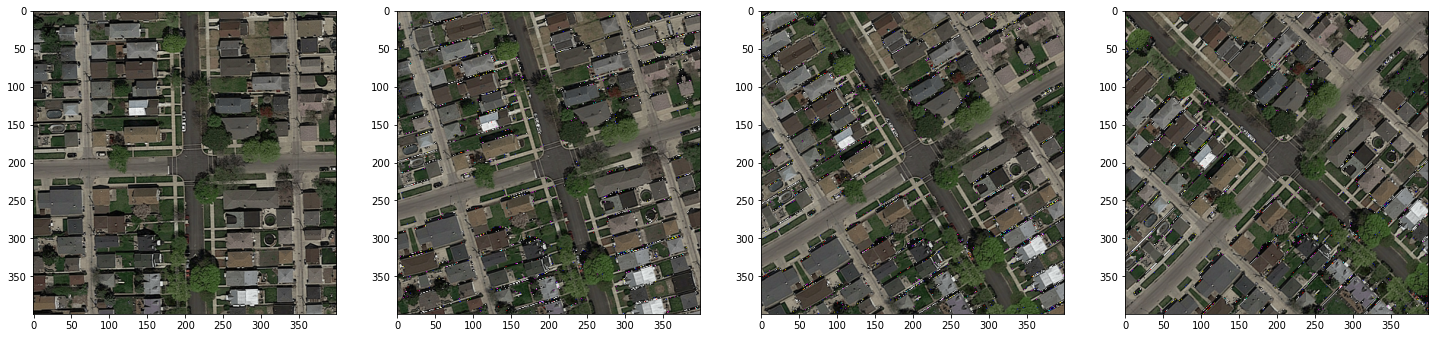

In [ ]:
# Just for testing
root_dir = "/content/drive/MyDrive/ml_epfl/ml_road_segmentation/data/training/images/"
files = os.listdir(root_dir)
to_tensor = T.ToTensor()
imgs = [to_tensor(Image.open(root_dir + files[i])) for i in range(1)]

ANGLE_ROTATION = 15
NB_ROT = 3
rot_imgs = imgs + [torch.from_numpy(sc.rotate(imgs[i], ANGLE_ROTATION*(idx_rot+1), axes =(1,2), reshape=False, mode="mirror")) for idx_rot in range(NB_ROT) for i in range(len(imgs)) ]

plt.figure(figsize=(25,25))
for i, image in enumerate(rot_imgs):
    plt.subplot(1, 4, i+1)
    plt.imshow(toPIL(image))